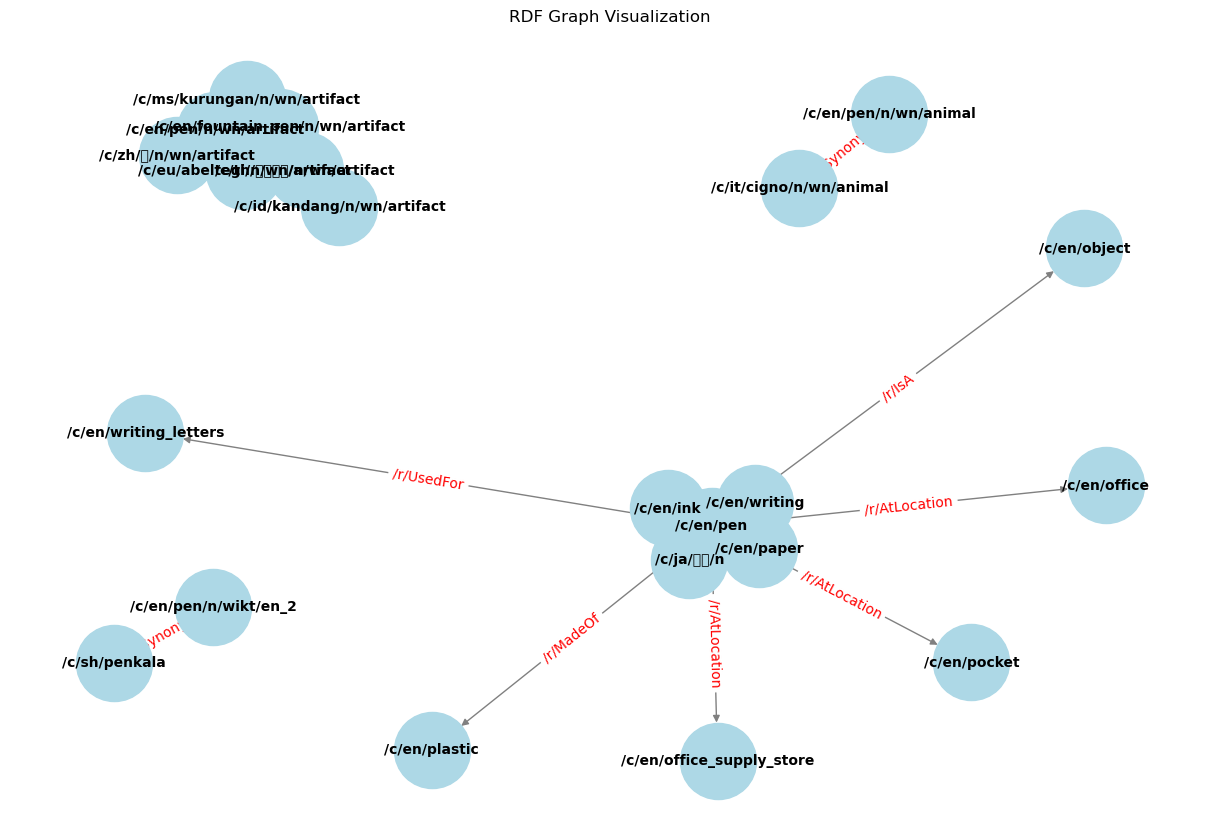

In [73]:
import requests
from rdflib import Graph, URIRef, Literal, Namespace
import networkx as nx
import matplotlib.pyplot as plt

def get_conceptnet_relationships_as_rdf(term, lang="en"):
    base_url = "http://api.conceptnet.io/"
    term_url = f"{base_url}c/{lang}/{term}"
    response = requests.get(term_url).json()
    edges = response.get('edges', [])
    g = Graph()
    CN = Namespace(base_url)
    g.bind("cn", CN)
    for edge in edges:
        start_node = URIRef(edge['start']['@id'])
        end_node = URIRef(edge['end']['@id'])
        predicate = URIRef(edge['rel']['@id'])
        g.add((start_node, predicate, end_node))
    return g

def visualize_rdf_graph(rdf_graph):
    # Convert RDF graph to a NetworkX graph
    nx_graph = nx.DiGraph()
    
    for s, p, o in rdf_graph:
        nx_graph.add_edge(str(s), str(o), label=str(p))
    
    # Draw the graph
    pos = nx.spring_layout(nx_graph)  # Spring layout for better spacing
    plt.figure(figsize=(12, 8))
    
    # Draw nodes and edges
    nx.draw(nx_graph, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", edge_color="gray")
    
    # Draw edge labels
    edge_labels = nx.get_edge_attributes(nx_graph, 'label')
    nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_color="red")
    
    plt.title("RDF Graph Visualization")
    plt.show()

# Example usage
if __name__ == "__main__":
    word = "pen"
    rdf_graph = get_conceptnet_relationships_as_rdf(word)
    visualize_rdf_graph(rdf_graph)


In [ ]:
#First thing you need to bd using  graphDB
def insert_rdf_to_graphdb(rdf_graph, endpoint_url):
    """Insert RDF data into GraphDB repository, avoiding duplicates."""
    sparql = SPARQLWrapper(endpoint_url)
    sparql.setMethod(POST)
    sparql.setReturnFormat(JSON)
    
    CN = Namespace("http://api.conceptnet.io/")  # Namespace for ConceptNet
    
    for subject, predicate, obj in rdf_graph:
        # Ensure literals are handled properly
        obj_value = f"<{obj}>" if isinstance(obj, URIRef) else f'"{obj}"'
        
        # SPARQL query with FILTER NOT EXISTS
        query = f"""
            INSERT {{
                <{subject}> <{predicate}> {obj_value} .
            }}
            WHERE {{
                FILTER NOT EXISTS {{
                    <{subject}> <{predicate}> {obj_value} .
                }}
            }}
        """
        
        sparql.setQuery(query)
        
        try:
            # Send the query to the SPARQL endpoint
            sparql.query()
            print(f"Triple inserted: {subject} {predicate} {obj}")
        except Exception as e:
            print(f"Error inserting triple: {subject} {predicate} {obj}")
            print(f"Error: {e}")

# Main execution (rest of the code remains the same)
if __name__ == "__main__":
    term = "pen"
    try:
        # Fetch ConceptNet data
        raw_data = fetch_raw_conceptnet_data(term)
        # Convert to RDF
        rdf_graph = convert_conceptnet_data_to_rdf(raw_data)
        # GraphDB endpoint
        graphdb_url = "http://localhost:7200/repositories/RCRA/statements"
        # Insert RDF into GraphDB
        insert_rdf_to_graphdb(rdf_graph, graphdb_url)
    except Exception as e:
        print(f"Error: {e}")


Triple inserted: http://api.conceptnet.io/c/en/fountain_pen/n/wn/artifact http://api.conceptnet.io/r/IsA http://api.conceptnet.io/c/en/pen/n/wn/artifact
Triple inserted: http://api.conceptnet.io/c/en/pen http://api.conceptnet.io/r/AtLocation http://api.conceptnet.io/c/en/office
Triple inserted: http://api.conceptnet.io/c/id/kandang/n/wn/artifact http://api.conceptnet.io/r/Synonym http://api.conceptnet.io/c/en/pen/n/wn/artifact
Triple inserted: http://api.conceptnet.io/c/ms/kurungan/n/wn/artifact http://api.conceptnet.io/r/Synonym http://api.conceptnet.io/c/en/pen/n/wn/artifact
Triple inserted: http://api.conceptnet.io/c/it/cigno/n/wn/animal http://api.conceptnet.io/r/Synonym http://api.conceptnet.io/c/en/pen/n/wn/animal
Triple inserted: http://api.conceptnet.io/c/en/paper http://api.conceptnet.io/weight 2.681044572550035
Triple inserted: http://api.conceptnet.io/c/en/pen http://api.conceptnet.io/r/IsA http://api.conceptnet.io/c/en/object
Triple inserted: http://api.conceptnet.io/c/en/p

In [47]:
from SPARQLWrapper import SPARQLWrapper, JSON
import requests

def get_concept_description(concept, endpoint_url):
    def test_endpoint_connection():
        sparql = SPARQLWrapper(endpoint_url)
        sparql.setQuery("ASK { ?s ?p ?o }")  # Simple query to test connectivity
        sparql.setReturnFormat(JSON)
        sparql.addCustomHttpHeader("Accept", "application/sparql-results+json")
        try:
            sparql.query().convert()
            return True
        except Exception as e:
            return f"Error: Unable to connect to the endpoint. {str(e)}"

    connectivity_test = test_endpoint_connection()
    if connectivity_test is not True:
        return connectivity_test

    sparql_query = f"""
    PREFIX cn: <http://api.conceptnet.io/c/en/>
    SELECT ?subject ?predicate ?object
    WHERE {{
        ?subject ?predicate ?object .
        FILTER (?subject = <http://api.conceptnet.io/c/en/{concept}> || ?object = <http://api.conceptnet.io/c/en/{concept}>)
    }}
    LIMIT 1000
    """

    sparql = SPARQLWrapper(endpoint_url)
    sparql.setQuery(sparql_query)
    sparql.setReturnFormat(JSON)
    sparql.addCustomHttpHeader("Accept", "application/sparql-results+json")

    try:
        results = sparql.query().convert()

        # Helper function to extract the local name from a URI
        def extract_local_name(uri):
            return uri.split('/')[-1]  # Get the part after the last '/'

        # Organize triples by predicate
        relationships = {}
        if "results" in results and "bindings" in results["results"]:
            triples = results["results"]["bindings"]
            for triple in triples:
                predicate = extract_local_name(triple["predicate"]["value"])
                subject = extract_local_name(triple["subject"]["value"])
                object_ = extract_local_name(triple["object"]["value"])

                # Group by predicate
                if predicate not in relationships:
                    relationships[predicate] = []
                relationships[predicate].append((subject, object_))
        
        # Format the output
        description = f"Description for '{concept}':\n"
        if relationships:
            for predicate, pairs in relationships.items():
                description += f"\nRelationship: {predicate}\n"
                for subject, object_ in pairs:
                    description += f"  - {subject} → {object_}\n"
        else:
            description += "\nNo triples found for this concept."

        return description

    except Exception as e:
        return f"Error: {str(e)}"

# Example usage
endpoint_url = "http://localhost:7200/repositories/RCRA"
concept = "pen"
description = get_concept_description(concept, endpoint_url)
print(description)


Description for 'pen':

Relationship: AtLocation
  - pen → office
  - pen → pocket
  - pen → office_supply_store

Relationship: HasA
  - pen → ink

Relationship: weight
  - pen → 4.47213595499958
  - pen → 5.656854249492381
  - pen → 2.0
  - pen → 2.82842712474619
  - pen → 7.211102550927979

Relationship: IsA
  - pen → object

Relationship: UsedFor
  - pen → writing_letters

Relationship: MadeOf
  - pen → plastic

Relationship: RelatedTo
  - paper → pen
  - writing → pen
  - ink → pen

Relationship: Synonym
  - n → pen

Relationship: HasPrerequisite
  - writing → pen

